# 집 값 예측 프로젝트     

#### 루브릭 
1. 캐글 데이터분석 전과정이 성공적으로 진행되었는가?<br>
데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 만든 csv파일을 캐글 My submission까지 진행했고, submission 결과를 이미지로 제출하였다.     

2. 전처리, 학습과정 및 결과에 대한 설명이 시각화를 포함하여 체계적으로 진행되었는가?<br>
제출한 주피터노트북 파일이 전처리, 학습, 최적화 진행 과정이 체계적으로 기술되었다.     

3. 회귀모델 예측정확도가 기준 이상 높게 나왔는가?<br>
다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 Private score 기준 110000 이하의 점수를 얻었다. 

In [339]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

print('부동산왕 동기화 중..')

부동산왕 동기화 중..


In [340]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

print(train_data_path)
print(sub_data_path)

/aiffel/aiffel/kaggle_kakr_housing/data/train.csv
/aiffel/aiffel/kaggle_kakr_housing/data/test.csv


In [341]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

## 1. 데이터 살펴보기

1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. **price : 타겟 변수인 집의 가격**
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [342]:
train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

print('train data dim : {}'.format(train.shape))
print('sub data dim : {}'.format(test.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


#### train은 15035개, test는 6468개의 데이터, test에는 target인 price가 빠져 컬럼 개수가 하나 적다.

In [343]:
train

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,15030,20141014T000000,610685.0,4,2.50,2520,6023,2.0,0,0,...,9,2520,0,2014,0,98056,47.5137,-122.167,2520,6023
15031,15031,20150326T000000,1007500.0,4,3.50,3510,7200,2.0,0,0,...,9,2600,910,2009,0,98136,47.5537,-122.398,2050,6200
15032,15032,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
15033,15033,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200


In [344]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  object 
 2   price          15035 non-null  float64
 3   bedrooms       15035 non-null  int64  
 4   bathrooms      15035 non-null  float64
 5   sqft_living    15035 non-null  int64  
 6   sqft_lot       15035 non-null  int64  
 7   floors         15035 non-null  float64
 8   waterfront     15035 non-null  int64  
 9   view           15035 non-null  int64  
 10  condition      15035 non-null  int64  
 11  grade          15035 non-null  int64  
 12  sqft_above     15035 non-null  int64  
 13  sqft_basement  15035 non-null  int64  
 14  yr_built       15035 non-null  int64  
 15  yr_renovated   15035 non-null  int64  
 16  zipcode        15035 non-null  int64  
 17  lat            15035 non-null  float64
 18  long  

In [345]:
train.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,15035.000000,1.503500e+04,15035.000000,15035.000000,15035.000000,1.503500e+04,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000
mean,7517.000000,5.406827e+05,3.369139,2.115065,2083.790223,1.529697e+04,1.498071,0.007117,0.234253,3.406651,7.660725,1794.158164,289.632059,1971.100432,83.798936,98078.031726,47.560721,-122.213677,1992.754772,12823.884935
std,4340.374984,3.715247e+05,0.902721,0.767519,922.134087,4.261282e+04,0.538522,0.084063,0.763376,0.646505,1.179803,831.738609,440.663284,29.407612,400.398498,53.297815,0.138164,0.141294,691.456442,27736.259787
min,0.000000,7.800000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,3758.500000,3.220000e+05,3.000000,1.750000,1430.000000,5.027500e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.472700,-122.328000,1490.000000,5100.000000
50%,7517.000000,4.500000e+05,3.000000,2.250000,1910.000000,7.620000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1570.000000,0.000000,1975.000000,0.000000,98065.000000,47.571900,-122.231000,1850.000000,7610.000000
75%,11275.500000,6.450000e+05,4.000000,2.500000,2560.000000,1.069550e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2230.000000,550.000000,1997.000000,0.000000,98117.000000,47.678300,-122.126000,2360.000000,10076.000000
max,15034.000000,7.700000e+06,10.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4130.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [346]:
test

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6463,21498,20140626T000000,3,1.75,1500,11968,1.0,0,0,3,6,1500,0,2014,0,98010,47.3095,-122.002,1320,11303
6464,21499,20150126T000000,3,2.00,1490,1126,3.0,0,0,3,8,1490,0,2014,0,98144,47.5699,-122.288,1400,1230
6465,21500,20150219T000000,3,2.50,1310,1294,2.0,0,0,3,8,1180,130,2008,0,98116,47.5773,-122.409,1330,1265
6466,21501,20140623T000000,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007


In [347]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6468 entries, 0 to 6467
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             6468 non-null   int64  
 1   date           6468 non-null   object 
 2   bedrooms       6468 non-null   int64  
 3   bathrooms      6468 non-null   float64
 4   sqft_living    6468 non-null   int64  
 5   sqft_lot       6468 non-null   int64  
 6   floors         6468 non-null   float64
 7   waterfront     6468 non-null   int64  
 8   view           6468 non-null   int64  
 9   condition      6468 non-null   int64  
 10  grade          6468 non-null   int64  
 11  sqft_above     6468 non-null   int64  
 12  sqft_basement  6468 non-null   int64  
 13  yr_built       6468 non-null   int64  
 14  yr_renovated   6468 non-null   int64  
 15  zipcode        6468 non-null   int64  
 16  lat            6468 non-null   float64
 17  long           6468 non-null   float64
 18  sqft_liv

## 2. 전처리 
#### 결측치 처리 

In [348]:
train.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [349]:
test.isnull().sum()

id               0
date             0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

train과 test 모두 결측치는 없다. 

#### 컬럼 정리 

In [350]:
# id 컬럼 삭제
del train['id']

In [351]:
# date 컬럼의 연, 월만 year, month로 컬럼으로 만들고, 나머지는 지운다. 
train['year'] = train['date'].apply(lambda x : str(x[:4])).astype(str)
train['month'] = train['date'].apply(lambda x : str(x[4:6])).astype(str)
test['year'] = test['date'].apply(lambda x : str(x[:4])).astype(str)
test['month'] = test['date'].apply(lambda x : str(x[4:6])).astype(str)

del train['date']
del test['date']
train.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,...,0,1955,0,98178,47.5112,-122.257,1340,5650,2014,10
1,180000.0,2,1.00,770,10000,1.0,0,0,3,6,...,0,1933,0,98028,47.7379,-122.233,2720,8062,2015,02
2,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,...,0,1987,0,98074,47.6168,-122.045,1800,7503,2015,02
3,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,...,0,1995,0,98003,47.3097,-122.327,2238,6819,2014,06
4,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,...,0,1963,0,98198,47.4095,-122.315,1650,9711,2015,01


In [352]:
# year, month 컬럼을 정수형으로 바꾼다. 
train = train.astype({'year':'int64'})
train = train.astype({'month':'int64'})
test = test.astype({'year':'int64'})
test = test.astype({'month':'int64'})

이상하게 astype으로 두개의 컬럼의 데이터 타입을 한번에 바꾸면 두번째가 안 변하는 문제가 생겼다. 

#### 각 변수들의 분포 확인과 로그 

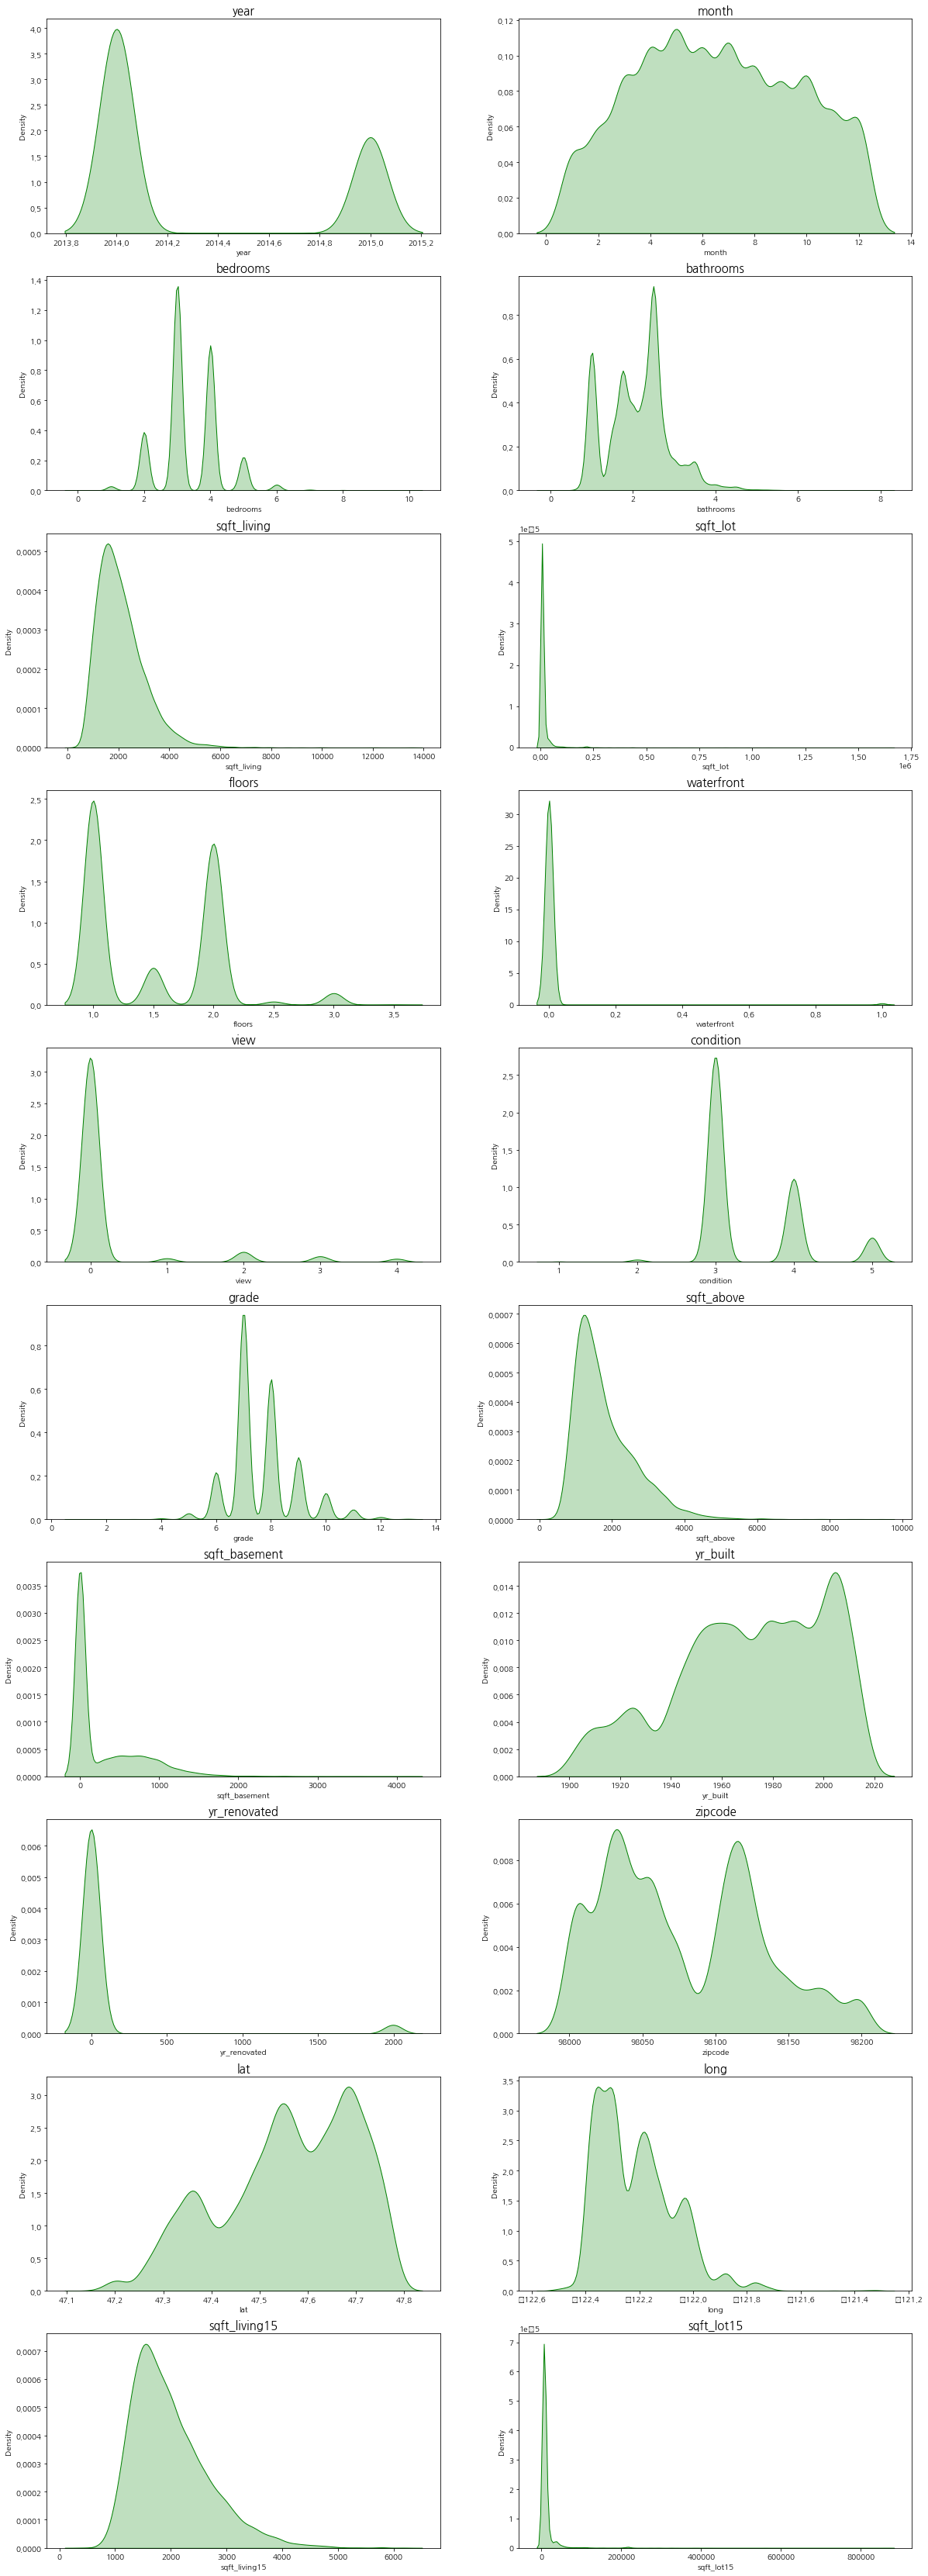

In [353]:
train_columns = ['year', 'month', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 
                 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 
                 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']
        
fig, ax = plt.subplots(10, 2, figsize=(20, 60)) 
count = 0                    
for row in range(10):
    for col in range(2): 
        sns.kdeplot(data=train[train_columns[count]], ax=ax[row][col], color = 'g', shade=True) # shade=True : 그래프 안 채우기 
        ax[row][col].set_title(train_columns[count], fontsize=15) # date 제외한 컬럼의 확률밀도함수출력 
        count += 1
        if count == 20 :
            break 

REF)    
https://darkpgmr.tistory.com/147 커널밀도추정(KDE) 그래프란?     
https://hleecaster.com/python-seaborn-kdeplot/ KDE plot 활용 

bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement, sqft_lot15 그래프가 한쪽으로 치우친 경향을 보인다. 그래서 log-scaling을 해보았다. 

In [354]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15']

for c in skew_columns:
    train[c] = np.log1p(train[c].values)

print('부동산왕 동기화 중..')

부동산왕 동기화 중..


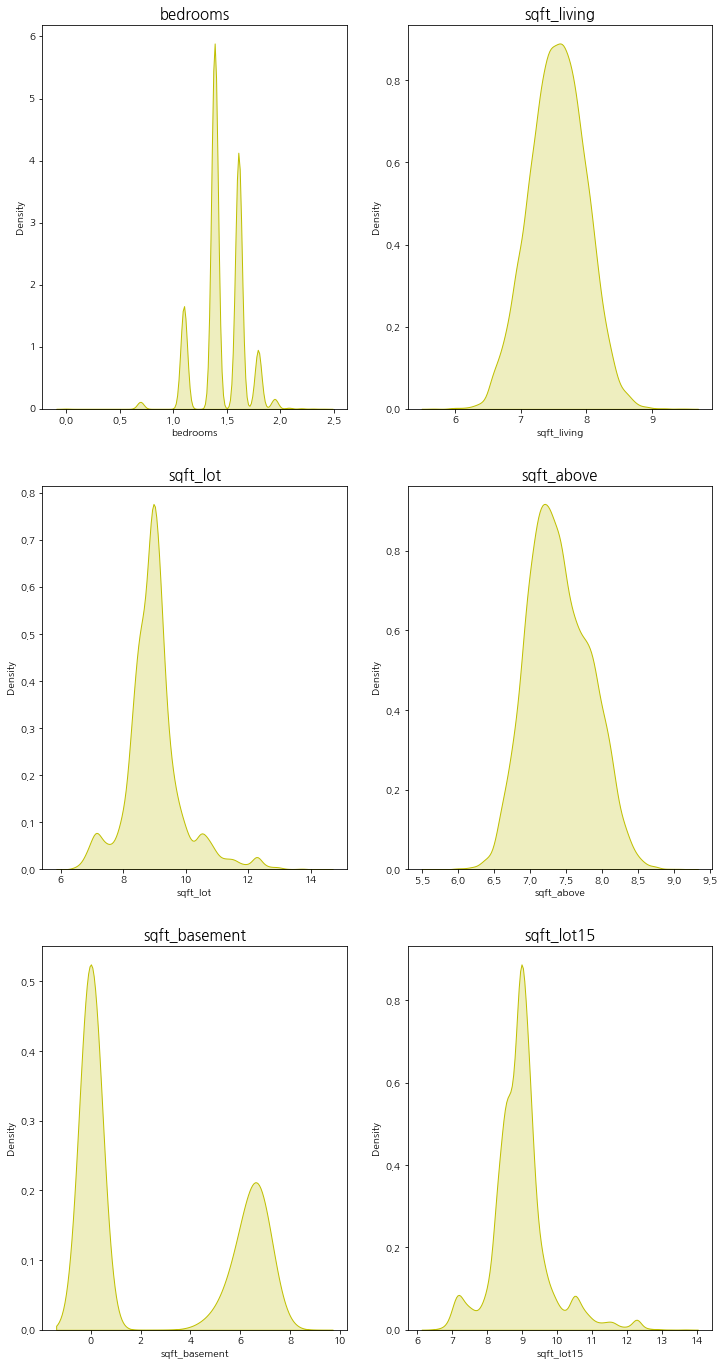

In [355]:
fig, ax = plt.subplots(3, 2, figsize=(12, 24))

count = 0
for row in range(3):
    for col in range(2):
        if count == 7:
            break
        sns.kdeplot(data=train[skew_columns[count]], ax=ax[row][col], color = 'y', shade=True)
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

대부분의 그래프가 정규분포에 가깝게 변했다. <br>
minmax scaler, standard scaler도 사용해보았는데, 오히려 로그를 취했을 때 더 정규분포에 가까웠다. <br>
test에도 같은 작업을 해주었다. 

In [356]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15']

for c in skew_columns:
    test[c] = np.log1p(test[c].values)

test.head()

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month
0,15035,1.386294,2.25,7.852050,8.887791,2.0,0,0,3,7,...,5.993961,1951,1991,98125,47.7210,-122.319,1690,8.941153,2014,12
1,15036,1.609438,3.00,7.581210,8.517393,1.0,0,0,5,7,...,6.814543,1965,0,98136,47.5208,-122.393,1360,8.517393,2014,12
2,15037,1.609438,4.50,8.598036,11.532051,1.0,0,0,3,11,...,7.333676,2001,0,98053,47.6561,-122.005,4760,11.532051,2014,5
3,15038,1.386294,1.00,7.484930,8.918784,1.0,0,0,3,7,...,6.594413,1960,0,98146,47.5123,-122.337,1780,9.001346,2015,4
4,15039,1.386294,2.50,7.544861,8.788898,2.0,0,0,3,7,...,0.000000,2003,0,98038,47.3684,-122.031,2390,8.932080,2015,3


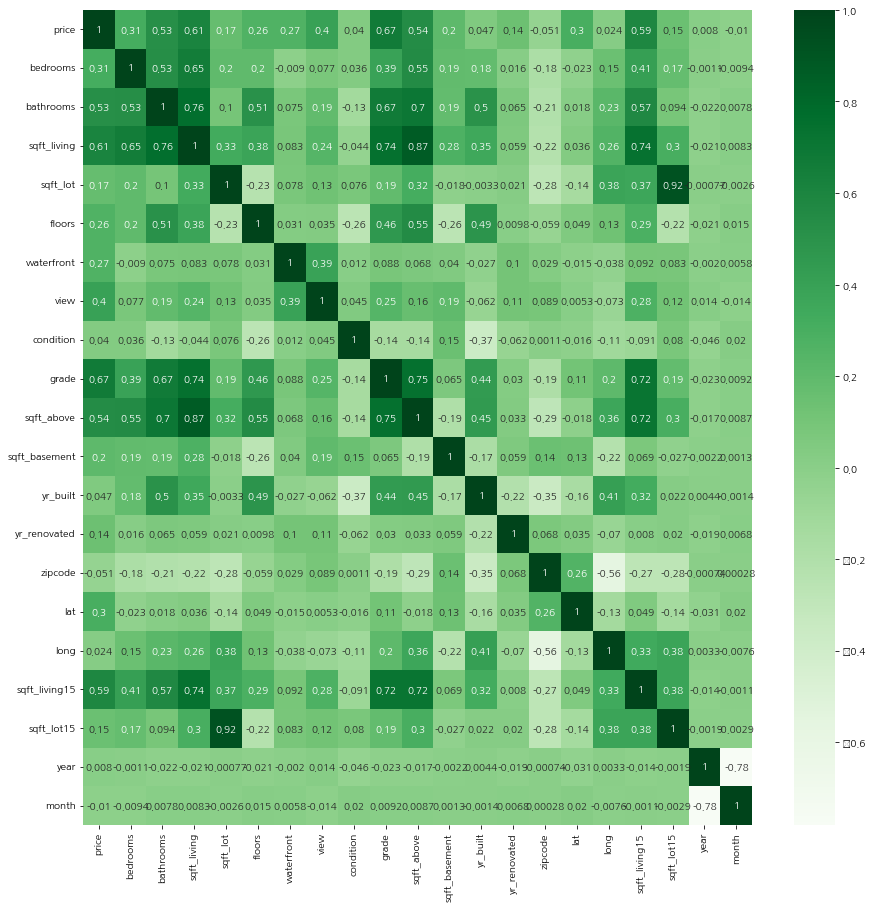

In [357]:
# 상관계수
fig, ax = plt.subplots(figsize=(15,15))     

sns.heatmap(train.corr(), annot = True, cmap = 'Greens')
plt.show()

price와의 상관계수의 절댓값이 0.5 이상인 컬럼으로는 sqft_living, bathrooms, grade, sqft_above, sqft_living15이 있다. <br>
집값이 대체로 집의 거실 면적, 침실 개수, 등급에 비례함을 알 수 있다. 

## 3. EDA

In [358]:
# 재건축 전후 거실, 부지 면적 차이 
# train['rv_living_gap'] = train['sqft_living15'] - train['sqft_living']
# train['rv_lot_gap'] = train['sqft_lot15'] - train['sqft_lot']
# train.head()

yr_renovated = 0 이면, 재건축을 안한 건물이라고 생각했는데, 재건축년도를 모르는 건물도 0으로 써놓은 것 같다. <br>
예를 들어 id=2, 3 건물의 경우 yr_renovated = 0임에도 불구하고, <br>
rv_living_gap, rv_lot_gap 컬럼은 0이 아닌 숫자인 것으로 보아, 거실, 부지 면적이 변화했음을 확인할 수 있다. 

In [359]:
# temp_living_gap = train.groupby(['rv_living_gap'])['price'].mean()

# plt.rc('font', family='NanumGothic')
# plt.figure(figsize=(20, 4))
# temp_living_gap.plot(kind='bar', rot=0)
# plt.title('재건축 전후 거실 면적 변화에 따른 집값')
# plt.xlabel('재건축 후 거실 면적 - 재건축 전 거실 면적')
# plt.ylabel('집값')
# plt.show()

이상하게도 재건축 후 거실 면적이 좁아졌을 수록 집값이 크게 나타난다. 

In [360]:
# temp_lot_gap = train.groupby(['rv_lot_gap'])['price'].mean()

# plt.rc('font', family='NanumGothic')
# plt.figure(figsize=(20, 4))
# temp_lot_gap.plot(kind='bar', rot=0)
# plt.title('재건축 전후 부지 면적 변화에 따른 집값')
# plt.xlabel('재건축 후 부지 면적 - 재건축 전 부지 면적')
# plt.ylabel('집값')
# plt.show()

부지 면적도 대체로 재건축 후 좁아졌을 때, 집값이 높은 것으로 나타난다. <br>
아무래도 sqft_living15, sqft_lot15 컬럼을 잘못 파악하고 있는 것 같아서 rv_living_gap, rv_lot_gap 컬럼은 지워야겠다. 

In [361]:
# rv_living_gap, rv_lot_gap 컬럼 삭제 
# train = train.drop(['rv_living_gap', 'rv_lot_gap'], axis = 1)
# train.head()

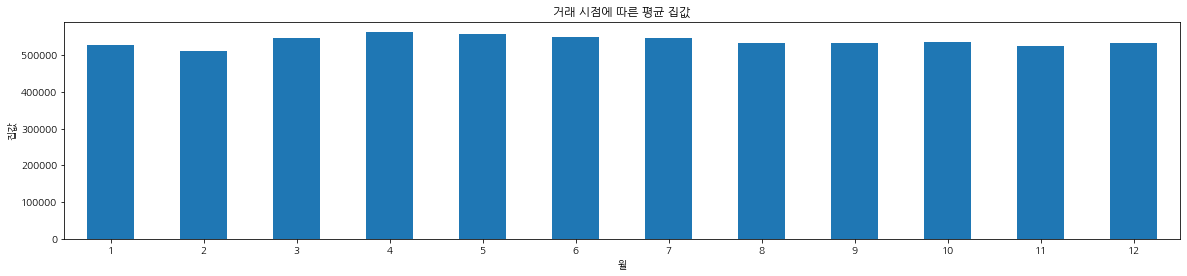

In [362]:
# 거래 시점에 따른 평균 집값
temp_month = train.groupby(['month'])['price'].mean()

plt.rc('font', family='NanumGothic')
plt.figure(figsize=(20, 4))
temp_month.plot(kind='bar', rot=0)
plt.title('거래 시점에 따른 평균 집값')
plt.xlabel('월')
plt.ylabel('집값')
plt.show()

월별로 거래된 평균 집값이 차이가 있을 것이라고 예상했으나, 미미했다. 
그래도 겨울보다는 4~7월에 거래된 집값의 평균이 약간 더 높다. 

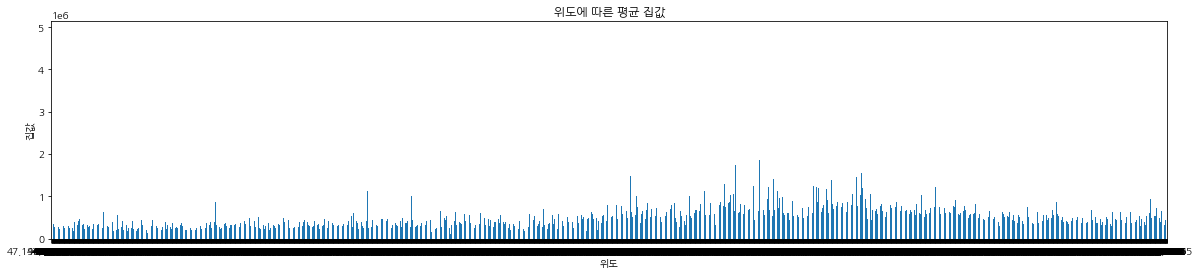

In [363]:
# 위도에 따른 평균 집값 그래프 
temp_lat = train.groupby(['lat'])['price'].mean()

plt.rc('font', family='NanumGothic')
plt.figure(figsize=(20, 4))
temp_lat.plot(kind='bar', rot=0)
plt.title('위도에 따른 평균 집값')
plt.xlabel('위도')
plt.ylabel('집값')
plt.show()

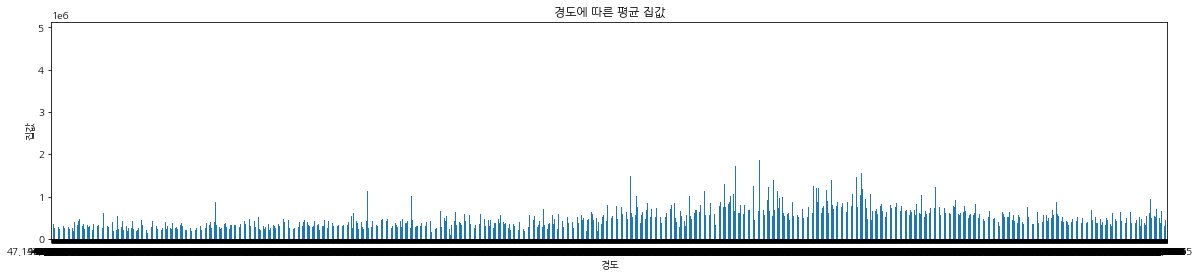

In [364]:
# 경도에 따른 평균 집값 그래프 
temp_long = train.groupby(['long'])['price'].mean()

plt.rc('font', family='NanumGothic')
plt.figure(figsize=(20, 4))
temp_lat.plot(kind='bar', rot=0)
plt.title('경도에 따른 평균 집값')
plt.xlabel('경도')
plt.ylabel('집값')
plt.show()

In [365]:
# 우편번호의 종류 오름차순 정렬 
zc = train['zipcode'].unique()
np.sort(zc)

array([98001, 98002, 98003, 98004, 98005, 98006, 98007, 98008, 98010,
       98011, 98014, 98019, 98022, 98023, 98024, 98027, 98028, 98029,
       98030, 98031, 98032, 98033, 98034, 98038, 98039, 98040, 98042,
       98045, 98052, 98053, 98055, 98056, 98058, 98059, 98065, 98070,
       98072, 98074, 98075, 98077, 98092, 98102, 98103, 98105, 98106,
       98107, 98108, 98109, 98112, 98115, 98116, 98117, 98118, 98119,
       98122, 98125, 98126, 98133, 98136, 98144, 98146, 98148, 98155,
       98166, 98168, 98177, 98178, 98188, 98198, 98199])

REF)     
https://bskyvision.com/entry/python-%EB%84%98%ED%8C%8C%EC%9D%B4-%EB%B0%B0%EC%97%B4-%EB%82%B4%EB%A6%BC%EC%B0%A8%EC%88%9C%EC%9C%BC%EB%A1%9C-%EC%A0%95%EB%A0%AC%ED%95%98%EA%B8%B0 넘파이 정렬

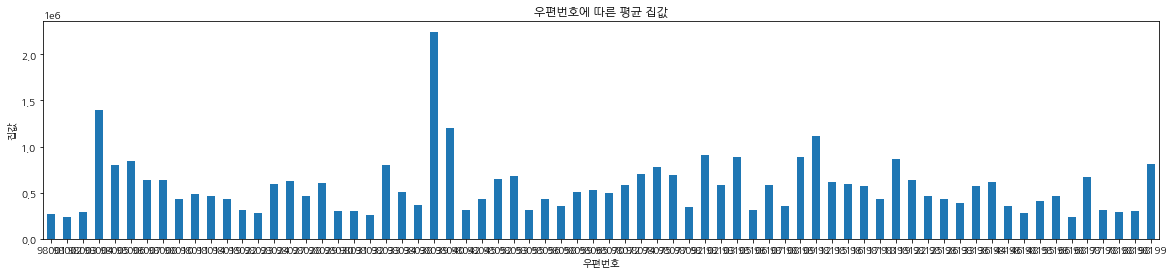

In [366]:
# 우편번호에 따른 평균 집값 그래프 
temp_zip = train.groupby(['zipcode'])['price'].mean()

plt.rc('font', family='NanumGothic')
plt.figure(figsize=(20, 4))
temp_zip.plot(kind='bar', rot=0)
plt.title('우편번호에 따른 평균 집값')
plt.xlabel('우편번호')
plt.ylabel('집값')
plt.show()

위도, 경도, 우편번호에 따른 집값의 평균 그래프를 보면, 사람들이 선호하는 특정 지역의 집값이 높음을 확인할 수 있다.  <br> 
집값이 가장 높은 우편번호 98039를 검색해보면 Washington 주의 Medina 지역이다. <br>
Lake Washington으로 둘러싸인 지역이라 경관이 좋고, 16분만에 호수 건너 Seattle로 통근할 수 있어서 집값이 높은 것 같다. 

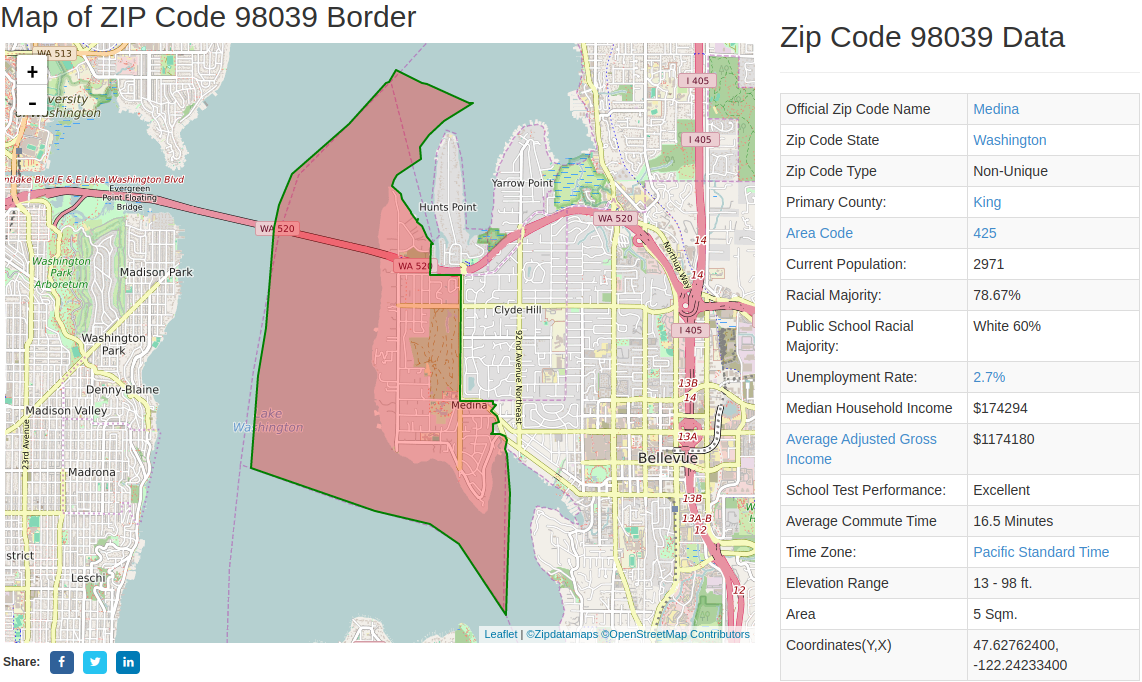

REF)    
https://www.zipdatamaps.com/98039 

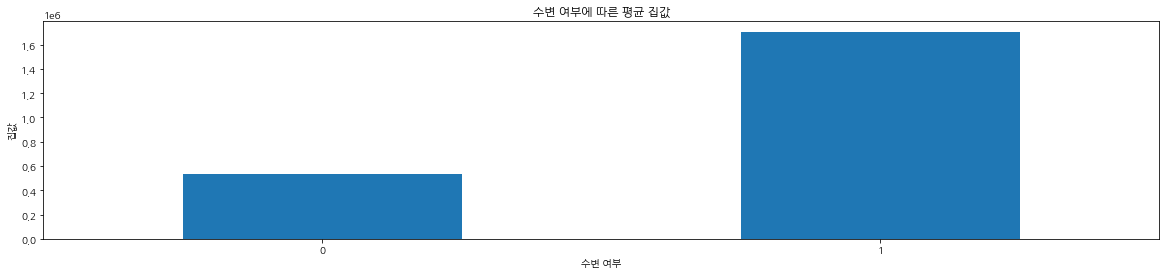

In [367]:
# 수변 여부에 따른 평균 집값 그래프 
temp_water = train.groupby(['waterfront'])['price'].mean()

plt.rc('font', family='NanumGothic')
plt.figure(figsize=(20, 4))
temp_water.plot(kind='bar', rot=0)
plt.title('수변 여부에 따른 평균 집값')
plt.xlabel('수변 여부')
plt.ylabel('집값')
plt.show()

호수, 강, 바다 등이 집 주변에 있을 때 평균 집값이 훨씬 높다. 

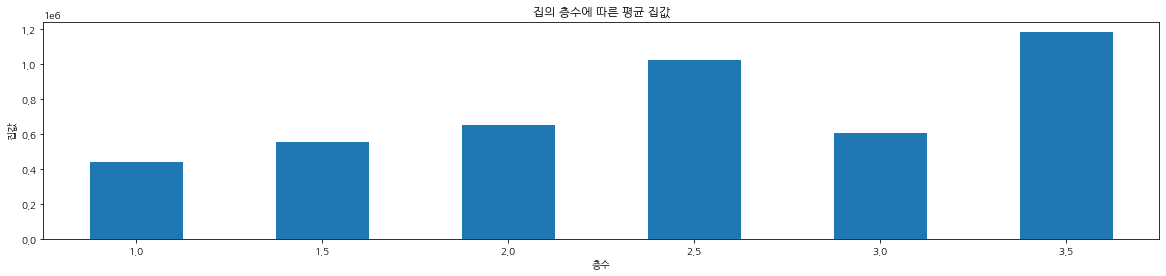

In [368]:
# 집의 층수에 따른 평균 집값 그래프 
temp_floors = train.groupby(['floors'])['price'].mean()

plt.rc('font', family='NanumGothic')
plt.figure(figsize=(20, 4))
temp_floors.plot(kind='bar', rot=0)
plt.title('집의 층수에 따른 평균 집값')
plt.xlabel('층수')
plt.ylabel('집값')
plt.show()

대체로 집의 층수가 높을수록 집값의 평균이 비싸지만, 2.5층일 때가 3층일 때보다 평균 집값이 높은 점이 특이하다.<br> 
3층보다 2.5층인 집을 선호하는 경향이 있거나, 데이터가 편향되었을 수도 있다. 

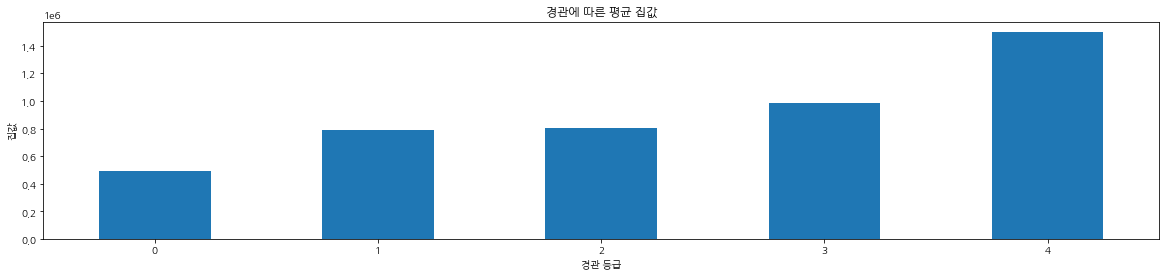

In [369]:
# 경관에 따른 평균 집값 그래프 
temp_view = train.groupby(['view'])['price'].mean()

plt.rc('font', family='NanumGothic')
plt.figure(figsize=(20, 4))
temp_view.plot(kind='bar', rot=0)
plt.title('경관에 따른 평균 집값')
plt.xlabel('경관 등급')
plt.ylabel('집값')
plt.show()

view의 등급이 높을수록 집값의 평균이 높다. 

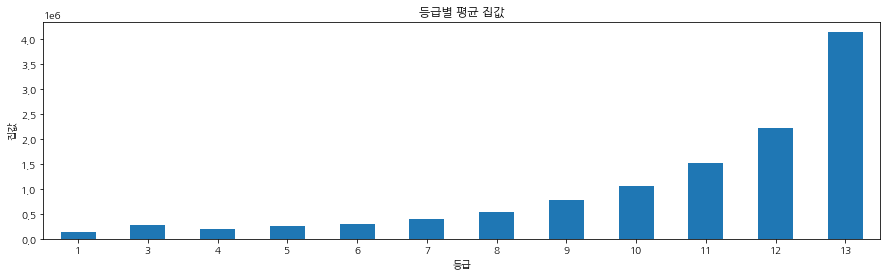

In [370]:
# 등급에 따른 평균 집값 그래프 
temp_grade = train.groupby(['grade'])['price'].mean()

plt.rc('font', family='NanumGothic')
plt.figure(figsize=(15, 4))
temp_grade.plot(kind='bar', rot=0)
plt.title('등급별 평균 집값')
plt.xlabel('등급')
plt.ylabel('집값')
plt.show()

grade가 높을수록 집값이 증가한다. 
#### price 살펴보기 

<AxesSubplot:>

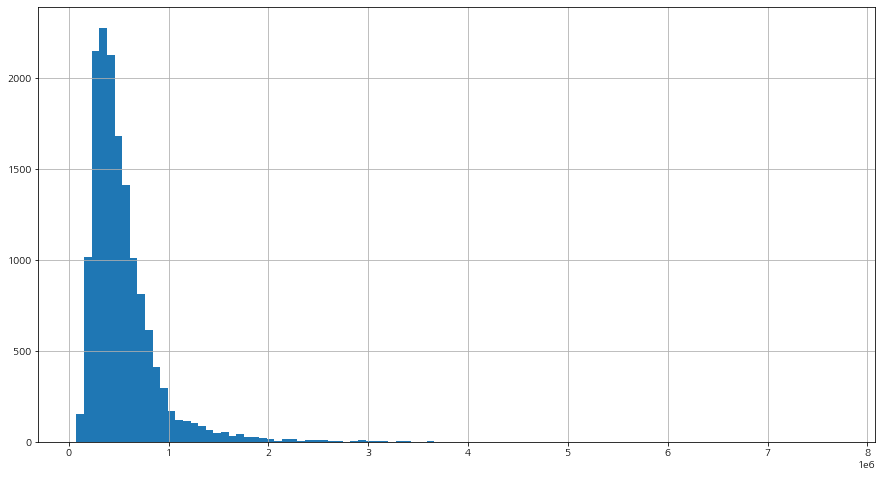

In [371]:
train['price'].hist(bins=100, figsize=(15,8))

히스토그램으로 price의 분포를 보면, 집값이 특정 값에 집중적으로 분포하며 그 이상의 가격에서는 분포가 완만하게 감소하고 있다. 

In [372]:
train['price'].describe()

count    1.503500e+04
mean     5.406827e+05
std      3.715247e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

describe를 통해 집값의 평균이 540,682임을 알 수 있다.<br> 
히스토그램의 분포로 보아 price의 최솟값인 78,000 이후로 집의 공급량이 급격히 증가해 평균값 이상에서 완만하게 감소한다.   

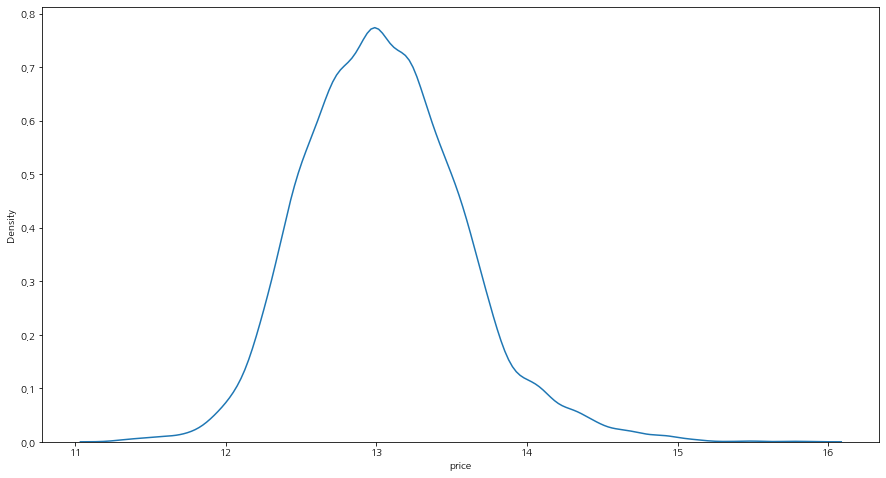

In [373]:
train['price'] = np.log1p(train['price'])

fig, ax = plt.subplots(figsize=(15,8))   
sns.kdeplot(train['price'])
plt.show()

In [374]:
# train의 target 분리 
y = train['price']

del train['price']

## 4. 모델링 

In [375]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=2023, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((12028, 20), (3007, 20), (12028,), (3007,))

In [376]:
# 선형 회귀
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model = LinearRegression()
model.fit(X_train, y_train) # x_train에 있는 값을 보고 y_train 맞추기
pred = model.predict(X_test)
mean_squared_error(y_test, pred)

0.06104500853261182

In [377]:
# 릿지 회귀
from sklearn.linear_model import Ridge

model = Ridge(alpha=1)
model.fit(X_train, y_train)
pred = model.predict(X_test)
mean_squared_error(y_test, pred)

0.061037152959927024

In [378]:
# 라쏘 회귀
from sklearn.linear_model import Lasso

model = Lasso()
model.fit(X_train, y_train)
pred = model.predict(X_test)
mean_squared_error(y_test, pred)

0.15530272196703507

In [379]:
# 엘라스틱넷 회귀
from sklearn.linear_model import ElasticNet

model = ElasticNet()
model.fit(X_train, y_train)
pred = model.predict(X_test)
mean_squared_error(y_test, pred)

0.1537216992848981

In [380]:
# 랜덤포레스트
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(random_state=2023)
model.fit(X_train, y_train)
pred = model.predict(X_test)
mean_squared_error(y_test, pred)

0.032241070379232004

In [300]:
# 하이퍼파라미터 튜닝
from sklearn.model_selection import RandomizedSearchCV

params = { 'n_estimators' : [10, 100],
           'max_depth' : [6, 8, 10, 12],
           'min_samples_leaf' : [8, 12, 18],
           'min_samples_split' : [8, 16, 20]
            }


#  Randomized Search
model = RandomForestRegressor()
grid = RandomizedSearchCV(model, params, cv=5, n_iter=10, n_jobs=-1) # n_iter 돌리는 횟수, n_jobs 코어 최대한 씀 
grid.fit(X_train, y_train)

# 최적의 하이퍼파라미터를 찾음
grid.best_params_

{'n_estimators': 100,
 'min_samples_split': 16,
 'min_samples_leaf': 8,
 'max_depth': 12}

In [305]:
# 최적의 하이퍼파라미터 적용 
model = RandomForestRegressor(random_state=2023, 
                      n_estimators = 100,
                      min_samples_split = 16,
                      min_samples_leaf = 8,
                      max_depth = 12   
                     )
model.fit(X_train, y_train)
pred = model.predict(X_test)
mean_squared_error(y_test, pred)

0.03552668701902182

RandomForest에 최적의 하이퍼 파라미터를 넣었는데, 오히려 mse값이 더 높아졌다. <br>
REF)    
https://injo.tistory.com/30 랜덤포레스트 하이퍼파라미터 튜닝

In [302]:
#  Gradient Boosting
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor(random_state=2023)

model.fit(X_train, y_train)
pred = model.predict(X_test)
mean_squared_error(y_test, pred)

0.03247491316438917

In [303]:
# Xgboost
from xgboost import XGBRegressor
model = XGBRegressor(random_state=2023)

model.fit(X_train, y_train)
pred = model.predict(X_test)
mean_squared_error(y_test, pred)

0.02794354430782766

In [313]:
# # 하이퍼파라미터 튜닝
# params={'learning_rate':[0.07, 0.05, 0.03], 
#         'max_depth':[6, 7, 8], 
#         'n_estimators':[300, 400, 500],
#         'subsample':[0.9, 0.8, 0.7]
#         }

# #  Randomized Search
# model = XGBRegressor()
# grid = RandomizedSearchCV(model, params, cv=3, n_iter=5, n_jobs=-1) # n_iter 돌리는 횟수, n_jobs 코어 최대한 씀 
# grid.fit(X_train, y_train)

# # 최적의 하이퍼파라미터를 찾음
# grid.best_params_

cv =10, n_inter=10으로 잘 돌아갔었는데, 다시 실행할때는 아무리 오래 기다려도 안돼서 주석처리했다. 

In [316]:
# 최적의 하이퍼파라미터 적용3 c=3
model = XGBRegressor(random_state=2023, 
                      max_depth = 7,
                      learning_rate = 0.07,
                      n_estimators = 300,
                      subsample = 0.7   
                     )
model.fit(X_train, y_train)
pred = model.predict(X_test)
mean_squared_error(y_test, pred)

0.02513445835567348

In [315]:
from lightgbm import LGBMRegressor
model = LGBMRegressor(random_state=2023)

model.fit(X_train, y_train)
pred = model.predict(X_test)
mean_squared_error(y_test, pred)

0.026424179269635927

In [317]:
# 하이퍼파라미터 튜닝
params={'learning_rate':[0.07, 0.05], 
        'max_depth':[5, 7, 9], 
        'n_estimators':[100, 200, 300],
        'subsample':[0.9, 0.8, 0.7],
        'min_data_in_leaf':[30, 50, 70] 
        
        }

#  Randomized Search
model = LGBMRegressor()
grid = RandomizedSearchCV(model, params, cv=5, n_iter=10, n_jobs=-1) # n_iter 돌리는 횟수, n_jobs 코어 최대한 씀 
grid.fit(X_train, y_train)

# 최적의 하이퍼파라미터를 찾음
grid.best_params_

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50


{'subsample': 0.9,
 'n_estimators': 200,
 'min_data_in_leaf': 50,
 'max_depth': 9,
 'learning_rate': 0.05}

In [319]:
# 최적의 하이퍼파라미터 적용2 cv=10 
model = LGBMRegressor(random_state=2023, 
                      learning_rate = 0.07,
                      n_estimators = 300,
                      subsample = 0.8,
                      max_depth = 9,
                      min_data_in_leaf = 50
                      
                     )
model.fit(X_train, y_train)
pred = model.predict(X_test)
mean_squared_error(y_test, pred)

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50


0.025495036305383984

LGBM Regressor에 최적의 하이퍼 파라미터를 넣었더니 0.001 정도 낮아졌다. cv=50으로 설정했을 때 보다, cv=10일 때의 파라미터가 mse가 낮았다. <br>
REF) <br>
https://velog.io/@sset2323/04-07.-LightGBM     
https://nurilee.com/2020/04/03/lightgbm-definition-parameter-tuning/ LGBM Regressor 하이퍼 파라미터 튜닝    

#### 베이스라인만으로 Kaggle에 제출했을 때 score가 116129점이 나왔다.     


## 앙상블 
### Average Blending
여러가지 모델의 결과를 산술 평균을 통해 Blending 모델을 만들겠습니다.

In [381]:
randomforest = RandomForestRegressor(random_state=2023)
gradientboost = GradientBoostingRegressor(random_state=2023)
xgboost = xgb.XGBRegressor(random_state=2023, max_depth = 7, learning_rate = 0.07, n_estimators = 300, subsample = 0.7)
lightgbm = lgb.LGBMRegressor(random_state=2023, learning_rate = 0.07, n_estimators = 300, subsample = 0.8, max_depth = 9, min_data_in_leaf = 50)

models = [{'model':randomforest, 'name':'RandomForest'}, {'model':gradientboost, 'name':'GradientBoost'},
          {'model':xgboost, 'name':'XGBoost'}, {'model':lightgbm, 'name':'LightGBM'}]

print('부동산왕 동기화 중..')

부동산왕 동기화 중..


###  Cross Validation

In [382]:
def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(train.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=train.values, y=y, cv=kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")
print('부동산왕 동기화 중..')

부동산왕 동기화 중..


In [383]:
get_cv_score(models)

Model: RandomForest, CV score:0.8849
Model: GradientBoost, CV score:0.8792
Model: XGBoost, CV score:0.9063
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
Model: LightGBM, CV score:0.9059


In [384]:
def AveragingBlending(models, train, y, sub_x):
    for m in models : 
        m['model'].fit(train.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

print('부동산왕 동기화 중..')

부동산왕 동기화 중..


In [385]:
sub_id =  test['id']
sub_id 

0       15035
1       15036
2       15037
3       15038
4       15039
        ...  
6463    21498
6464    21499
6465    21500
6466    21501
6467    21502
Name: id, Length: 6468, dtype: int64

In [389]:
del test['id']

In [390]:
y_pred = AveragingBlending(models, train, y, test)

y_pred = np.expm1(y_pred)
print(len(y_pred))
y_pred

6468


array([ 514626.87064385,  447900.98561206, 1326540.26077685, ...,
        464819.55497876,  325396.46217655,  434260.6867421 ])

In [391]:
result = pd.DataFrame({
    'id' : sub_id, 
    'price' : y_pred
})

result.head()

,id,price
0,15035,5.146269e+05
1,15036,4.479010e+05
2,15037,1.326540e+06
3,15038,3.013152e+05
4,15039,3.184824e+05


In [392]:
my_submission_path = join(data_dir, 'submission_5.csv')
result.to_csv(my_submission_path, index=False)

print(my_submission_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission_5.csv


## 5. submission 결과 이미지 

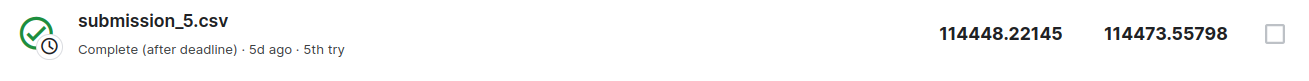

## 6. 회고

#### 헤맸던 것
- 베이스라인과 노드의 코드가 달라 에러나는게 많아서, 고치는데 시간이 걸렸다. 
- 일부 컬럼들에 로그를 취한 결과가 만족스럽지 않아, minmax, standard scaling을 해봤지만 차라리 로그가 나았다. 
- 군집화가 유용할 것 같아서 한참 해봤는데, 역시나 test에 price가 없으니 train에서 나눈 군집을 적용할 수 없었다. 
- train_test_split 할 때, train과 y의 개수가 달라 한참 헤맸다. 퍼실님 도움으로 train에 train_len 만큼의 데이터만 할당해 해결했다. 
- randomforest, xgboost, lightgbm 모델을 하이퍼파라미터 튜닝해봤는데, gridsearch가 너무 오래걸려 randomsearch로 바꾸었다. 그러나 cv와 파라미터의 범위를 바꿔 계속 시도하다보니 시간이 정말 많이 들었다. 그럼에도 불구하고 막상 csv 파일을 업로드했을 때 score는 별로 차이가 나지 않았다. 
- rmse만 따로 출력해서 보고 싶은데, 과거의 노드에서 코드를 가져와도 갖은 에러가 나서 여러 시도하는데 시간이 많이 들었다. 
- 하이퍼파라미터 튜닝 돌리고 앙상블해서 제출했더니 score가 60만이 넘었다. y_pred = np.expm1(y_pred)를 안 넣어서 그렇다는걸 나중에 발견했다.
- voting 등 다양한 시도를 해봤는데, 베이스라인에서 2천점이 떨어졌을 뿐, 도무지 11만점 이하로 떨어지지 않았다. 

#### 새롭게 알게된 것
- sub_id = data['id'][train_len:]코드에서 [train_len:]부분이 무슨 의미인지 이해가 안됐다. 퍼실님께 여쭤봐서 해당 부분 만큼은 슬라이싱해 떼어내버린 나머지를 말한다는걸 알았다.  
- info나 insnull외에도 msno.matrix()와 for문을 활용해 결측치를 확인할 수 있다. 
- 웬만한 다른 scaling 보다 로그가 낫다. 
- 군집화한 결과를 모델링에 사용하려면, 군집을 나누는 기준에 target이 들어가면 안되겠다. 
- GradientBoosting, LightGBM 모델을 알게되었다. 
- 하이퍼 파라미터 튜닝에서 cv를 크게 잡아 실행하는데 오래 걸린다고 해서, 결과가 그에 비례해 좋지만은 않다.  

#### 아직도 모르는 것 
- 결측치 확인할 때 isnull().sum()을 쓰지 않고, for문을 쓰는 이유가 뭘까? 같은 결과라도 코드를 짜는 사람마다 선호하는게 달라서 그런가...
- 이상치를 구분하고 제거하는게 아직도 잘 모르겠다. 
- wanterfront, view, floors, grade 컬럼의 크기에 평균 집값이 대체로 비례한다. 그러나 막상 상관계수를 보면 그닥 높지않다. 집값의 평균이라 사실상 개별 집값은 편차가 커서 그럴 수도 있지만, 이런 컬럼을 어떻게 다뤄야할 지를 모르겠다.
- eda를 통해 새롭게 파악한 내용이 모델링에 반영되도록 적용할 수 없었다. 
- rmse만 따로 출력하는 방법 
- kaggle에서 다른 사람들의 코드를 봐도, 어려워서 막상 내 프로젝트에 적용할 수 없었다.  
- 전처리와 피처 엔지니어링을 더 잘했어야하는건지, 다섯 번 제출해보고 더 이상 아이디어가 없어서 포기했다. 